## Code for training the noise model

Pixel noise models are a collection of probability distributions mapping from a true pixel intensity to observed noisy pixel measurements (and vice-versa).
They have been effectively used for unsupervised denoising, which we aim to replicate in our setup. Given a noisy pixel intensity, these models provide a distribution of potential clean signal values and their probabilities.

Physical Availability of Microscope
When the microscope is available, the same content is imaged 
𝑁 times to obtain 
𝑁 noisy versions of the specimen. A high-SNR version is generated by averaging the noisy samples pixel-wise, creating data pairs of clean signal values and 
𝑁 noisy intensities. This data is used to train a Gaussian-mixture noise model. To simulate this, noise (Gaussian and/or Poisson) is repeatedly added to intensity values in the range 
[0, 65535], [0,65535].

Physical Unavailability of Microscope
When the microscope is unavailable, as with publicly available datasets, DivNoising proposes a bootstrap noise model. Noisy data is denoised using unsupervised techniques, and the noisy/denoised pairs are used to train the noise model. To simulate this, noise is added to clean training data to produce noisy-clean pairs.

To address errors introduced by the denoising process, an additional method is tested: noise is added to clean data, and an off-the-shelf denoiser like N2V is used. The resulting noisy-denoised pairs are then used to train the noise model.

### Important ! 

This step can be skipped! Only run this notebook if you want to train the noise models from scratch. Pretrained noise models are available 

In [1]:
import numpy as np
import pooch
import matplotlib.pyplot as plt
from careamics import CAREamist
from careamics.models.lvae.noise_models import GaussianMixtureNoiseModel, create_histogram
from careamics.lvae_training.dataset import DataSplitType
from careamics.config import GaussianMixtureNMConfig
from careamics.config import create_n2v_configuration

from microsplit_reproducibility.configs.data.HT_P23B_2D import get_data_configs
from microsplit_reproducibility.datasets.HT_P23B import get_train_val_data
from microsplit_reproducibility.utils.utils import plot_probability_distribution



### Load and prepare data

Data preparation, dataset specific or load from function in this repo



In [2]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/microsplit/ht_p23b",
    registry={"ht_p23b.zip": None},
)

In [3]:
fp = DATA.fetch("ht_p23b.zip", processor=pooch.Unzip())

In [4]:
train_data_config, val_data_config, test_data_config = get_data_configs()

In [5]:
input_data = get_train_val_data(data_config=train_data_config,
                                datadir=DATA.path / "ht_p23b.zip.unzip/datafiles",
                                datasplit_type=DataSplitType.Train,
                                )

In [6]:
# We use a subset of the data for training the noise model
train_data = np.concatenate(input_data._data, axis=1).squeeze()[0:-1:10, ...]

### Create N2V configuration

In [7]:
config = create_n2v_configuration(
    experiment_name="ht_p23b_2d",
    data_type="array",
    axes="SYXC",
    n_channels=2,
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=1,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 2,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 2},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYXC',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
   

### Train N2V 

In [8]:
careamist = CAREamist(source=config)

# train
careamist.train(
        train_source=train_data,
        val_minimum_split=5,
    )

No working directory provided. Using current working directory: /home/igor.zubarev/projects/microSplit-reproducibility/examples/2D/HT_P23B.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [0.14922764 0.90080486], std: [0.47261239 0.9196914 ]
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/igor.zubarev/projects/microSplit-reproducibility/examples/2D/HT_P23B/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Para

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 53/53 [00:11<00:00,  4.46it/s, train_loss_step=0.969, val_loss=0.816, train_loss_epoch=0.921]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 53/53 [00:12<00:00,  4.35it/s, train_loss_step=0.969, val_loss=0.816, train_loss_epoch=0.921]


In [9]:
prediction = careamist.predict(train_data, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 384/384 [00:02<00:00, 149.47it/s]


### Visualize N2V predictions

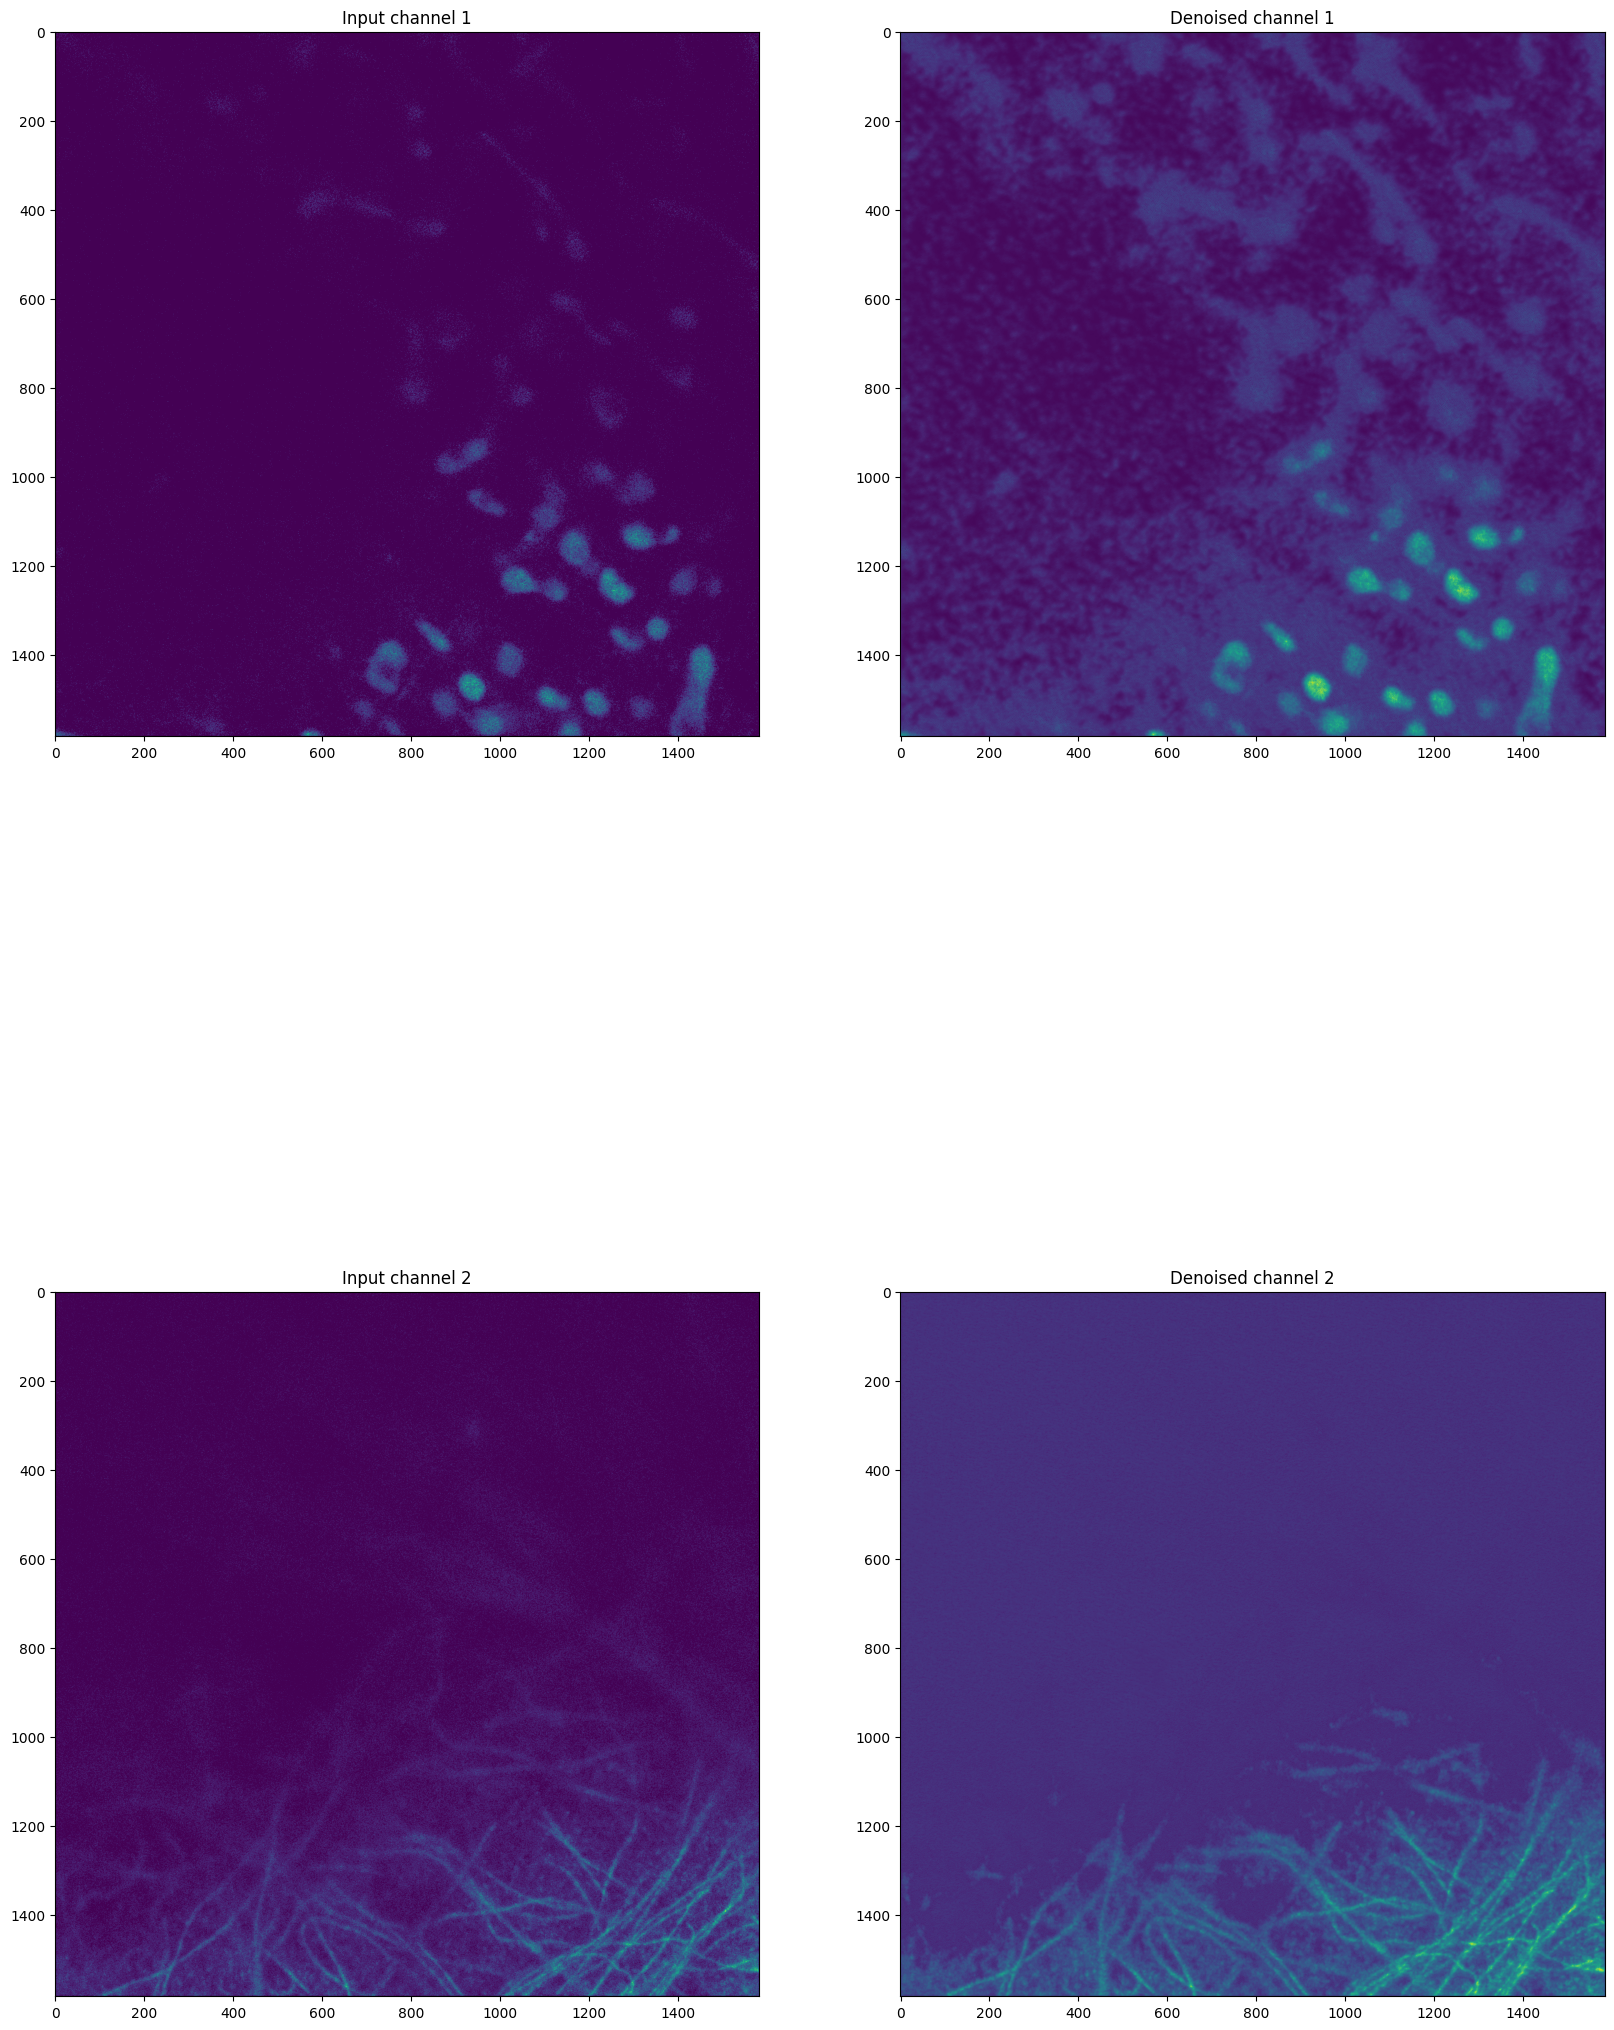

In [10]:
_, ax = plt.subplots(2, 2, figsize=(20, 30))
ax[0][0].imshow(train_data[0, ..., 0])
ax[0][0].set_title("Input channel 1")
ax[0][1].imshow(prediction[0].squeeze()[0])
ax[0][1].set_title("Denoised channel 1")
ax[1][0].imshow(train_data[0, ..., 1])
ax[1][0].set_title("Input channel 2")
ax[1][1].imshow(prediction[0].squeeze()[1])
ax[1][1].set_title("Denoised channel 2")
plt.show()

### Train the noise model and visualize the results

Here we train a noise model using the denoised images aquired from the N2V model.

We train a separate noise model for each channel.


In [23]:
for channel_idx in range(train_data.shape[-1]):
    channel_data = train_data[..., channel_idx]
    channel_prediction = np.concatenate(prediction)[:, channel_idx]
    print(f"Training noise model for channel {channel_idx}")
    noise_model_config = GaussianMixtureNMConfig(
        model_type="GaussianMixtureNoiseModel",
        min_signal=channel_data.min(),
        max_signal=channel_data.max(),
    )
    noise_model = GaussianMixtureNoiseModel(noise_model_config)
    print(noise_model.weight)
    noise_model.fit(
        signal=channel_data, observation=channel_prediction, n_epochs=1000
    )  # TODO change n_epochs
    print(noise_model.weight)
    noise_model.save(path="noise_models", name=f"nm_ht_p23b_2d_ch{channel_idx + 1}")
    histogram = create_histogram(
        bins=100,
        min_val=channel_data.min(),
        max_val=channel_data.max(),
        signal=channel_data,
        observation=channel_prediction,
    )
    plot_probability_distribution(
        noise_model, signalBinIndex=50, histogram=histogram[0], channel=channel_idx
    )

Training noise model for channel 0
[GaussianMixtureNoiseModel] min_sigma: 200.0
tensor([[-0.1501, -0.5940],
        [ 0.2531,  2.4849],
        [ 0.6664, -0.1645]], device='cuda:0', requires_grad=True)
0 3.5696239471435547
100 3.569633443756859
200 3.5696333107070544
300 3.569633243883963
400 3.569633172337254
500 3.569633115551429
600 3.569633112175889
700 3.5696330883363516
800 3.569633099023769
900 3.569633126920389

tensor([[-0.1501, -0.5940],
        [ 0.2531,  2.4849],
        [-0.5002, -0.4056]], device='cuda:0', requires_grad=True)
The trained parameters (nm_ht_p23b_2d_ch1) is saved at location: noise_models


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!